In [1]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [2]:
now = datetime.datetime.now()

In [3]:
train_df = pd.read_csv('dataset/train_13_2335.csv')
test_df = pd.read_csv('dataset/test_13_2335.csv')

In [4]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns=['y', 'id'])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

# ・RANDOM FOREST

In [7]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [8]:
train_score_rf = rf.score(x_train, y_train)
test_score_rf = rf.score(x_test, y_test)

rf_p = rf.predict(x_test)

acc_rf = accuracy_score(rf_p, y_test)
auc_rf = roc_auc_score(rf_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_rf, test_score_rf))
print('acc:{}, auc:{}'.format(acc_rf, auc_rf))

train score:0.9998616236162362, test_score:0.9293357933579336
acc:0.9293357933579336, auc:0.839435321219418


In [13]:
%%time

rf_params = {
    'n_estimators': [1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in np.arange(3,10)],
    'min_samples_split': [i for i in np.arange(5,15)],
    'min_samples_leaf': [i for i in np.arange(1,5)],
    'random_state': [18]
}

rf = RandomForestClassifier() 
gs_rf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=skf, n_jobs=-1)
gs_rf.fit(x_train, y_train)

print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.9301660516605166
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 1000, 'random_state': 18}
CPU times: user 19.5 s, sys: 1.72 s, total: 21.2 s
Wall time: 1h 16min 18s


In [30]:
rf_best_params = {
    'n_estimators': 1000,
    'criterion': 'gini',
    'max_depth': 9,
    'min_samples_leaf': 1,
    'min_samples_split': 11,
    'random_state': 18
}

best_rf = RandomForestClassifier(**rf_best_params)
best_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_split=11, n_estimators=1000,
                       random_state=18)

In [14]:
train_score_gsrf = gs_rf.score(x_train, y_train)
test_score_gsrf = gs_rf.score(x_test, y_test)

gsrf_p = gs_rf.predict(x_test)

acc_gsrf = accuracy_score(gsrf_p, y_test)
auc_gsrf = roc_auc_score(gsrf_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_gsrf, test_score_gsrf))
print('acc:{}, auc:{}'.format(acc_gsrf, auc_gsrf))

train score:0.9338560885608856, test_score:0.9280442804428044
acc:0.9280442804428044, auc:0.8628332021921288


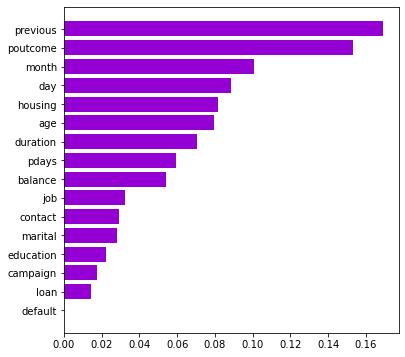

In [40]:
features = x_train.columns
importances = best_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='darkviolet', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [15]:
pred_rf = gs_rf.predict_proba(test_df)
rf_p = pd.DataFrame(pred_rf)
rf_p.head()

,0,1
0,0.280026,0.719974
1,0.935705,0.064295
2,0.956255,0.043745
3,0.995485,0.004515
4,0.908989,0.091011


In [33]:
rf_name = 'models/RF_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(best_rf, open(rf_name, 'wb'))

# ・LightGBM

In [16]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [17]:
lgb_model = lgb.LGBMClassifier(n_estimators=1000, random_state=18, n_jobs=2)
lgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=30, verbose=100)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.207925


LGBMClassifier(n_estimators=1000, n_jobs=2, random_state=18)

In [18]:
train_score_lgb = lgb_model.score(x_train, y_train)
test_score_lgb = lgb_model.score(x_test, y_test)

lgb_p = lgb_model.predict(x_test)

acc_lgb = accuracy_score(lgb_p, y_test)
auc_lgb = roc_auc_score(lgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_lgb, test_score_lgb))
print('acc:{}, auc:{}'.format(acc_lgb, auc_lgb))

train score:0.9392988929889299, test_score:0.9311808118081181
acc:0.9311808118081181, auc:0.830093850568061


In [19]:
%%time

params_lgb = {
    'learning_rate': [i for i in np.arange(0.01, 0.05, 0.01)],
    'max_depth': [i for i in np.arange(3, 10)],
    'min_child_weight': [i for i in np.arange(1, 5)],
    'feature fraction': [i for i in np.arange(0.80, 0.95, 0.05)],
    'subsample': [i for i in np.arange(0.3, 0.9, 0.1)]
}

lgb_model = lgb.LGBMClassifier(n_estimators=1000, random_state=18, n_jobs=3)
gs_lgb = GridSearchCV(lgb_model, param_grid=params_lgb, cv=skf, n_jobs=2)
gs_lgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=30)

print(gs_lgb.best_score_)
print(gs_lgb.best_params_)

[1]	valid_0's binary_logloss: 0.268948
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.265517
[3]	valid_0's binary_logloss: 0.262798
[4]	valid_0's binary_logloss: 0.260575
[5]	valid_0's binary_logloss: 0.258727
[6]	valid_0's binary_logloss: 0.256738
[7]	valid_0's binary_logloss: 0.255004
[8]	valid_0's binary_logloss: 0.2535
[9]	valid_0's binary_logloss: 0.252028
[10]	valid_0's binary_logloss: 0.250961
[11]	valid_0's binary_logloss: 0.249776
[12]	valid_0's binary_logloss: 0.248685
[13]	valid_0's binary_logloss: 0.247688
[14]	valid_0's binary_logloss: 0.246778
[15]	valid_0's binary_logloss: 0.245754
[16]	valid_0's binary_logloss: 0.244998
[17]	valid_0's binary_logloss: 0.244183
[18]	valid_0's binary_logloss: 0.243481
[19]	valid_0's binary_logloss: 0.242747
[20]	valid_0's binary_logloss: 0.242166
[21]	valid_0's binary_logloss: 0.241372
[22]	valid_0's binary_logloss: 0.240662
[23]	valid_0's binary_logloss: 0.240147
[24]	valid_0's binary_logloss:

In [35]:
lgb_best_params = {
    'n_estimators': 1000,
    'feature fraction': 0.8,
    'learning_rate': 0.04,
    'max_depth': 3,
    'min_child_weight': 3, 
    'subsample': 0.3
}

best_lgb = lgb.LGBMClassifier(**lgb_best_params)
best_lgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=30)

[1]	valid_0's binary_logloss: 0.268948
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.265517
[3]	valid_0's binary_logloss: 0.262798
[4]	valid_0's binary_logloss: 0.260575
[5]	valid_0's binary_logloss: 0.258727
[6]	valid_0's binary_logloss: 0.256738
[7]	valid_0's binary_logloss: 0.255004
[8]	valid_0's binary_logloss: 0.2535
[9]	valid_0's binary_logloss: 0.252028
[10]	valid_0's binary_logloss: 0.250961
[11]	valid_0's binary_logloss: 0.249776
[12]	valid_0's binary_logloss: 0.248685
[13]	valid_0's binary_logloss: 0.247688
[14]	valid_0's binary_logloss: 0.246778
[15]	valid_0's binary_logloss: 0.245754
[16]	valid_0's binary_logloss: 0.244998
[17]	valid_0's binary_logloss: 0.244183
[18]	valid_0's binary_logloss: 0.243481
[19]	valid_0's binary_logloss: 0.242747
[20]	valid_0's binary_logloss: 0.242166
[21]	valid_0's binary_logloss: 0.241372
[22]	valid_0's binary_logloss: 0.240662
[23]	valid_0's binary_logloss: 0.240147
[24]	valid_0's binary_logloss:

LGBMClassifier(feature fraction=0.8, learning_rate=0.04, max_depth=3,
               min_child_weight=3, n_estimators=1000, subsample=0.3)

In [20]:
train_score_gslgb = gs_lgb.score(x_train, y_train)
test_score_gslgb = gs_lgb.score(x_test, y_test)

gslgb_p = gs_lgb.predict(x_test)

acc_gslgb = accuracy_score(gslgb_p, y_test)
auc_gslgb = roc_auc_score(gslgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_gslgb, test_score_gslgb))
print('acc:{}, auc:{}'.format(acc_gslgb, auc_gslgb))

train score:0.9362084870848708, test_score:0.9311808118081181
acc:0.9311808118081181, auc:0.830093850568061


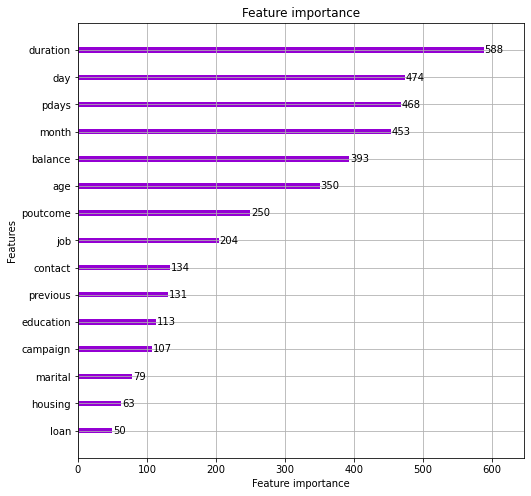

In [39]:
lgb.plot_importance(best_lgb, figsize=(8,8), color='darkviolet')

In [21]:
pred_lgb = gs_lgb.predict_proba(test_df)
lgb_p = pd.DataFrame(pred_lgb)
lgb_p.head()

,0,1
0,0.093899,0.906101
1,0.911938,0.088062
2,0.970994,0.029006
3,0.996928,0.003072
4,0.971005,0.028995


In [37]:
lgb_name = 'models/LGBM_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(best_lgb, open(lgb_name, 'wb'))

# ・SUBMIT

In [27]:
pred = pd.DataFrame({
    'RandomForest': rf_p[1],
    'LightGBM': lgb_p[1]
})

pred.head()

,RandomForest,LightGBM
0,0.719974,0.906101
1,0.064295,0.088062
2,0.043745,0.029006
3,0.004515,0.003072
4,0.091011,0.028995


In [28]:
pred['sum'] = pred.sum(axis=1)
pred['pred'] = pred.RandomForest * 0.2 + pred.LightGBM * 0.8
pred.head()

,RandomForest,LightGBM,sum,pred
0,0.719974,0.906101,1.626075,0.868876
1,0.064295,0.088062,0.152357,0.083309
2,0.043745,0.029006,0.072751,0.031954
3,0.004515,0.003072,0.007588,0.003361
4,0.091011,0.028995,0.120006,0.041398


In [29]:
submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [25]:
# RandomForest

submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['RandomForest']
})

file_name = 'submit/submit_RF' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [26]:
# LightGBM

submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['LightGBM']
})

file_name = 'submit/submit_LGBM' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)